In [31]:
import os
import pathlib
import numpy as np

initial_triplet_training=False
triplet_training=True
embeddings_size=16
ap_pairs_train=15
an_pairs_train=15
ap_pairs_test=5
an_pairs_test=5

knn_neighbors=15
nc_function='knn'
p_value_type='regular'
significance_levels=np.arange(start=0.01,stop=0.4,step=0.002)

c_count = 0
o_count = 0
p_count = 0
r_count = 0
s_count = 0
check = 1001

train_images_path = '/mnt/hdd/gbowlds/images/100k/train'
val_images_path = '/mnt/hdd/gbowlds/images/100k/val'
lbls_path = pathlib.Path('/mnt/hdd/gbowlds/nclabels/labels/bdd100k_nclabels_images_train.json')
val_lbls_path = pathlib.Path('/mnt/hdd/gbowlds/nclabels/labels/bdd100k_nclabels_images_val.json')

triplet_network_arch_path='Saved_Models/triplet_nn_structure.json'
triplet_network_weights_path='Saved_Models/triplet_model_weights.h5'
training_triplets_path='GeneratedData/train_pairs.npy'
validation_triplets_path='GeneratedData/test_pairs.npy'
data_per_class_path='GeneratedData/data_per_class.npy'
triplet_embeddings_path='GeneratedData/triplet_embeddings.pickle'
knn_nc_scores_path='GeneratedData/knn_nc_scores.pickle'
nearest_centroid_nc_scores_path='GeneratedData/nearest_centroid_nc_scores.pickle'
prediction_sets_path='GeneratedData/prediction_sets.pickle'
optimal_epsilon_path='GeneratedData/optimal_epsilon.npy'
test_pvalues_path='GeneratedData/test_pvalues.npy'


In [16]:
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import csv
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
import json
from tqdm.notebook import tqdm
from PIL import Image
from itertools import permutations

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Input, GlobalAveragePooling2D, Lambda, Reshape, Conv2DTranspose, DepthwiseConv2D, concatenate
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam

In [3]:
config = tf.compat.v1.ConfigProto()
# adjust the amount of memory you allow it to use as needed
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.compat.v1.Session(config=config)

In [17]:
def make_train_lists(sample: str):
    image_path = pathlib.Path(train_images_path + '/' + sample['name'])
    data = np.array(Image.open(image_path).resize((224,224)))
    weather = sample['attributes']['weather']
    tod = sample['attributes']['timeofday']
    
    if tod == 'daytime' and weather != 'foggy' and weather != 'undefined':
        if weather == 'clear':
            global c_count
            c_count = c_count+1
            if c_count < check:
                w_data = 0
            else:
                w_data = 5
        elif weather == 'overcast':
            global o_count
            o_count = o_count+1
            if o_count < check:
                w_data = 1
            else:
                w_data = 5
        elif weather == 'partly cloudy':
            global p_count
            p_count = p_count+1
            if p_count < check:
                w_data = 2
            else:
                w_data = 5
            
        elif weather == 'rainy':
            global r_count
            r_count  = r_count+1
            if r_count < check:
                w_data = 3
            else:
                w_data = 5
            
        elif weather == 'snowy':
            global s_count
            s_count = s_count + 1
            if s_count < check:
                w_data = 4
            else:
                w_data = 5
            
            
        if w_data != 5:
            train_images.append(data)
            train_labels.append(w_data)

In [18]:
def make_val_lists(sample: str):
    image_path = pathlib.Path(val_images_path + '/' + sample['name'])
    data = np.array(Image.open(image_path).resize((224,224)))
    weather = sample['attributes']['weather']
    tod = sample['attributes']['timeofday']
    
    if tod == 'daytime' and weather != 'foggy' and weather != 'undefined':
        if weather == 'clear':
            w_data = 0
        elif weather == 'overcast':
            w_data = 1
        elif weather == 'partly cloudy':
            w_data = 2
        elif weather == 'rainy':
            w_data = 3
        elif weather == 'snowy':
            w_data = 4
        val_images.append(data)
        val_labels.append(w_data)

In [19]:
train_images = []
train_labels = []
val_images = []
val_labels = []

with open(lbls_path) as lbls_file:
        samples = json.load(lbls_file)
        random.shuffle(samples)
    
        for sample in tqdm(samples):
            if len(train_images) < 5000:
                make_train_lists(sample)
train_images = np.asarray(train_images)

with open (val_lbls_path) as lbls_file:
        samples = json.load(lbls_file)
        random.shuffle(samples)
    
        for sample in tqdm(samples):
            if len(val_images) < 1000:
                make_val_lists(sample)
                
val_images = np.array(val_images)

num_classes= 5

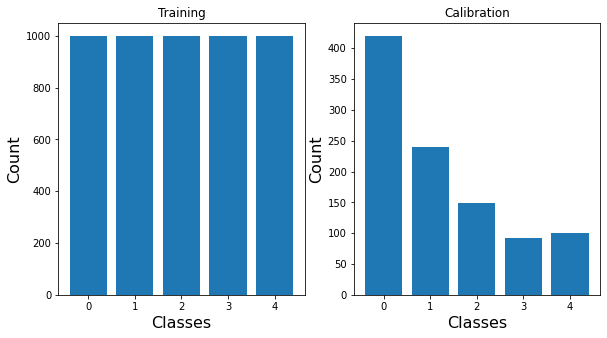

In [20]:
fig=plt.figure()
fig.set_size_inches(15,5)
label_counter=Counter(train_labels)
ax1=fig.add_subplot(131)
ax1.set_ylabel('Count',color='k',fontsize=16)
ax1.set_xlabel('Classes',color='k',fontsize=16)
ax1.bar(label_counter.keys(), label_counter.values())
ax1.grid(False)
ax1.set_title("Training")

label_counter=Counter(val_labels)
ax2=fig.add_subplot(132)
ax2.set_ylabel('Count',color='k',fontsize=16)
ax2.set_xlabel('Classes',color='k',fontsize=16)
ax2.bar(label_counter.keys(), label_counter.values())
ax2.grid(False)
ax2.set_title("Calibration")

fig.show()

In [21]:
def class_separation(train_images,train_labels):
    class_idxs=[]
    for data_class in sorted(set(train_labels)):
        class_idxs.append(np.where((train_labels == data_class))[0])
    return class_idxs

def generate_hard_positives_hard_negatives(train_images,train_labels,idxs_per_class,samples_per_class,model):
    num_of_classes=len(set(train_labels))
    samples=np.empty((num_of_classes,samples_per_class),dtype='int')
    #pick samples_per_class samples per class
    for data_class in sorted(set(train_labels)):
        
        samples[data_class]=random.sample(list(idxs_per_class[data_class]),k=samples_per_class)

    Anchor=[]
    Positive=[]
    Negative=[]

    count=0
    for data_class in sorted(set(train_labels)):
        print("class:",data_class)
        Embeddings_in=model.predict(train_images[samples[data_class]])

        different_classes_idxs=samples[np.arange(len(set(train_labels)))!=data_class].flatten()
        Embeddings_out=model.predict(train_images[different_classes_idxs])


        for i in range(samples_per_class):
            Anchor_embedding=Embeddings_in[i]
            other_positives_idxs=np.arange(samples_per_class)[np.arange(samples_per_class)!=i]
            Positive_embeddings=Embeddings_in[other_positives_idxs]
            positive_distances=(Positive_embeddings-Anchor_embedding)**2
            positive_distances=np.sum(positive_distances,axis=1)
            hard_positive_idx=np.argmax(positive_distances)

            negative_distances=(Embeddings_out-Anchor_embedding)**2
            negative_distances=np.sum(negative_distances,axis=1)
            
            for j in range(len(different_classes_idxs)):
                if negative_distances[j]<positive_distances[hard_positive_idx]:
                    Anchor.append(train_images[samples[data_class,i]])
                    Positive.append(train_images[samples[data_class,other_positives_idxs[hard_positive_idx]]])
                    Negative.append(train_images[different_classes_idxs[j]])
        print(len(Anchor))


    Anchor=np.array(Anchor)
    Positive=np.array(Positive)
    Negative=np.array(Negative)

    return Anchor,Positive,Negative

def generate_random_triplets(train_images, train_labels, val_images, val_labels,ap_pairs_train,an_pairs_train,
                             ap_pairs_test,an_pairs_test):

    triplet_train_pairs = []
    triplet_test_pairs = []

    #train
    print(sorted(set(train_labels)))
    for data_class in sorted(set(train_labels)):
        same_class_idx = np.where((train_labels == data_class))[0]
        diff_class_idx = np.where(train_labels != data_class)[0]
        if (ap_pairs_train < len(list(permutations(same_class_idx,2)))):
            A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs_train) #Generating Anchor-Positive pairs
            Neg_idx = random.sample(list(diff_class_idx),k=an_pairs_train)
            A_P_len = len(A_P_pairs)
            Neg_len = len(Neg_idx)
            for ap in A_P_pairs:
                Anchor = train_images[ap[0]]
                Positive = train_images[ap[1]]
                for n in Neg_idx:
                    Negative = train_images[0]
                    triplet_train_pairs.append([Anchor,Positive,Negative])   
            print("Pairs generated for: " + str(data_class))
    #test
    data_class = 0
    for data_class in sorted(set(val_labels)):
        same_class_idx = np.where((val_labels == data_class))[0]
        diff_class_idx = np.where(val_labels != data_class)[0]
        if (ap_pairs_test < len(list(permutations(same_class_idx,2)))):
            A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs_test) #Generating Anchor-Positive pairs
            Neg_idx = random.sample(list(diff_class_idx),k=an_pairs_test)
            A_P_len = len(A_P_pairs)
            Neg_len = len(Neg_idx)
            for ap in A_P_pairs:
                Anchor = val_images[ap[0]]
                Positive = val_images[ap[1]]
                for n in Neg_idx:
                    Negative = val_images[n]
                    triplet_test_pairs.append([Anchor,Positive,Negative])
            print("Test pairs generated for: " + str(data_class))

    print(np.array(triplet_train_pairs).shape)
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [9]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [22]:
# from keras import backend as K
#from simple_FF import create_base_model
from triplet_loss import triplet_loss
model_path = pathlib.Path('/mnt/hdd/gbowlds/weather_model_resnet_2.h5')
in_dims=train_images.shape[1:]    
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
base_model= keras.models.load_model(model_path)
# Shared embedding layer for positive and negative items
anchor_input = Input((224,224,3), name='anchor_input')
positive_input = Input((224,224,3), name='positive_input')
negative_input = Input((224,224,3), name='negative_input')

base_model.layers.pop()
base_model.layers.pop()

encoded_anchor = base_model(anchor_input)
encoded_positive = base_model(positive_input)
encoded_negative = base_model(negative_input)

base_model.summary()

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)
model.summary()

#test_model=Model(inputs=anchor_input, outputs=encoded_anchor)
#test_model_json=test_model.to_json()

#if not os.path.exists('Saved_Models/'):
    #os.makedirs('Saved_Models/')
#with open(triplet_network_arch_path, "w") as json_file:
    #json_file.write(test_model_json)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [10]:
base_model.load_weights("/mnt/hdd/gbowlds/initial_triplet_base.h5")
model.load_weights("/mnt/hdd/gbowlds/initial_triplet.h5")

## Training

In [28]:
idxs_per_class=class_separation(train_images,train_labels)
callbacks=[]
# callbacks = [CSVLogger('Saved_Models/training.log',separator=' '),
#              EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)]

# model,test_model=create_triplet_nn(config.input_shape[dataset],dataset,nn_type,alpha,embedding_size)

if initial_triplet_training==True:
    train_labels = np.asarray(train_labels, dtype=np.int32)
    val_labels = np.asarray(val_labels, dtype=np.int32)
    X_train,X_test=generate_random_triplets(train_images, train_labels, val_images, val_labels,ap_pairs_train,an_pairs_train,ap_pairs_test,an_pairs_test)
    Anchor_test = X_test[:,0,:].reshape(-1,X_test.shape[2],X_test.shape[3],X_test.shape[4])
    Positive_test = X_test[:,1,:].reshape(-1,X_test.shape[2],X_test.shape[3],X_test.shape[4])
    Negative_test = X_test[:,2,:].reshape(-1,X_test.shape[2],X_test.shape[3],X_test.shape[4])
    
    Y_dummy2 = np.empty((Anchor_test.shape[0],1))
    
    Anchor = X_train[:,0,:].reshape(-1,X_train.shape[2],X_train.shape[3],X_train.shape[4])
    Positive = X_train[:,1,:].reshape(-1,X_train.shape[2],X_train.shape[3],X_train.shape[4])
    Negative = X_train[:,2,:].reshape(-1,X_train.shape[2],X_train.shape[3],X_train.shape[4])
    Y_dummy = np.empty((Anchor.shape[0],12))
    model.fit([Anchor,Positive,Negative],
        y=Y_dummy,
        validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),
        batch_size=32,
        epochs=1,
        verbose=1)
    base_model.save("/mnt/hdd/gbowlds/triplet_base.h5")
    model.save("/mnt/hdd/gbowlds/triplet.h5")

if triplet_training==True:
    train_labels = np.asarray(train_labels, dtype=np.int32)
    for i in range(10):
        print("iteration:",i)

        Anchor,Positive,Negative=generate_hard_positives_hard_negatives(train_images,train_labels,idxs_per_class,
                                                                        5,base_model)

        Y_dummy = np.empty((Anchor.shape[0],12))
        model.fit([Anchor,Positive,Negative],
            y=Y_dummy,
            # validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),
            batch_size=32,
            epochs=1,
            callbacks=callbacks,
            shuffle=True,
            verbose=1)
        base_model.save("/mnt/hdd/gbowlds/triplet_base_mined.h5")
        model.save("/mnt/hdd/gbowlds/triplet_mined.h5")

iteration: 0
class: 0
41
class: 1
76
class: 2
155
class: 3
210
class: 4
298
10/10 [==============================] - 85s 8s/step - loss: 0.2271
iteration: 1
class: 0
88
class: 1
127
class: 2
145
class: 3
207
class: 4
288
y_pred.shape =  Tensor("model_1/merged_layer/concat:0", shape=(32, 15), dtype=float32)
9/9 [==============================] - 82s 9s/step - loss: 0.2471
iteration: 2
class: 0
71
class: 1
107
class: 2
110
class: 3
159
class: 4
214
7/7 [==============================] - 58s 8s/step - loss: 0.4306
iteration: 3
class: 0
92
class: 1
152
class: 2
204
class: 3
248
class: 4
286
9/9 [==============================] - 81s 9s/step - loss: 0.5918
iteration: 4
class: 0
32
class: 1
101
class: 2
144
class: 3
144
class: 4
230
8/8 [==============================] - 63s 8s/step - loss: 0.6075
iteration: 5
class: 0
24
class: 1
67
class: 2
83
class: 3
90
class: 4
105
4/4 [==============================] - 23s 6s/step - loss: 0.2998
iteration: 6
class: 0
49
class: 1
126
class: 2
200
class:

## Generate Embeddings

In [29]:
from keras.models import model_from_json

#with open(triplet_network_arch_path, "r") as json_file:
 #   loaded_model_json=json_file.read()
#model=model_from_json(loaded_model_json)
#model.load_weights(triplet_network_weights_path)

train_embeds=base_model.predict(train_images)
calibration_embeds=base_model.predict(val_images)


## Evaluate triplet

In [25]:
import seaborn as sns

def scatter(x, labels, filename, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", np.max(labels)+1))

    # We create a scatter plot.
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=5,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(np.max(labels)+1):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=14)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)

    if not os.path.exists('Plots/'):
        os.makedirs('Plots/')
        
    plt.show()
    plt.savefig('Plots/'+"/"+filename)
    plt.close(fig)
    
def confusion_matrix(ground_truth_labels,predicted_labels,title,fsize):
    skplt.metrics.plot_confusion_matrix(ground_truth_labels, predicted_labels,title=title,figsize=fsize)


Train accuracy: 0.7278
Calibration accuracy: 0.609
Triplet train data silhouette: 0.23775212
Triplet validation data silhouette: 0.10568832


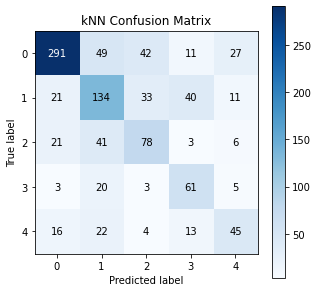

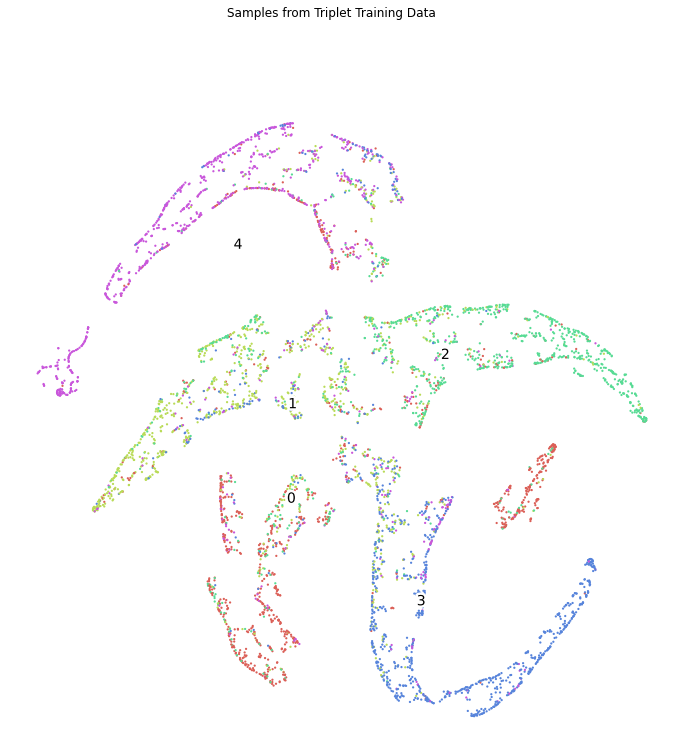

<Figure size 432x288 with 0 Axes>

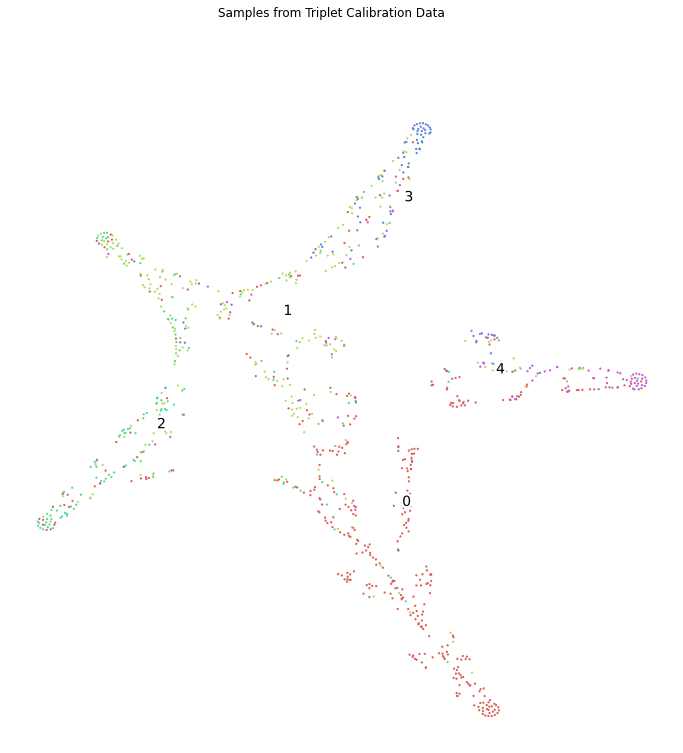

<Figure size 432x288 with 0 Axes>

In [30]:
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import scikitplot as skplt
import matplotlib.patheffects as PathEffects


#with open(triplet_embeddings_path, "rb") as f:
 #   train_embeds, calibration_embeds, test_embeds=pickle.load(f)

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_embeds, train_labels)
train_predictions=neigh.predict(train_embeds)
val_labels = np.asarray(val_labels, dtype=np.int32)
calibration_predictions=neigh.predict(calibration_embeds)
print("Train accuracy:",np.sum(train_predictions==train_labels)/train_labels.shape[0])
print("Calibration accuracy:",np.sum(calibration_predictions==val_labels)/val_labels.shape[0])
print("Triplet train data silhouette:", silhouette_score(train_embeds,train_labels))
print("Triplet validation data silhouette:", silhouette_score(calibration_embeds,val_labels))

confusion_matrix(val_labels,calibration_predictions,"kNN Confusion Matrix",(5,5))

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(train_embeds)
scatter(train_tsne_embeds, train_labels, filename='training_scatter', subtitle="Samples from Triplet Training Data")
calibration_tsne_embeds = tsne.fit_transform(calibration_embeds)
scatter(calibration_tsne_embeds, val_labels, filename='calibration_scatter', subtitle="Samples from Triplet Calibration Data")


## ICP Calibration

### K-NN

(array([123.,  65.,  94.,  66.,  70.,  59.,  74.,  46.,  45.,  49.,  51.,
         44.,  56., 158.]),
 array([ 0.        ,  1.07142857,  2.14285714,  3.21428571,  4.28571429,
         5.35714286,  6.42857143,  7.5       ,  8.57142857,  9.64285714,
        10.71428571, 11.78571429, 12.85714286, 13.92857143, 15.        ]),
 <a list of 14 Patch objects>)

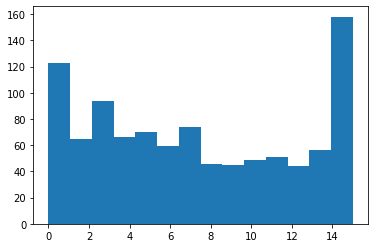

In [32]:
from sklearn.neighbors import NearestNeighbors

    
neigh = NearestNeighbors(n_neighbors=knn_neighbors, algorithm='kd_tree', metric='euclidean')
neigh.fit(train_embeds)
indices=neigh.kneighbors(calibration_embeds, return_distance=False)
calibration_nc=np.empty(len(val_labels))
for i in range(len(val_labels)):
    calibration_nc[i]=np.count_nonzero(train_labels[indices[i]]!=val_labels[i])
    
plt.hist(calibration_nc,bins=knn_neighbors-1)


### Nearest Centroid

In [33]:
from sklearn.neighbors import NearestNeighbors
    
centroids=np.empty((num_classes,embeddings_size))
for i in range(num_classes):
    centroids[i]=np.mean(train_embeds[train_labels==i],axis=0)

calibration_nc=np.empty(len(val_labels))
temp_distances=np.zeros(num_classes)
for i in range(len(val_labels)):
    for j in range(num_classes):
        temp_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
    calibration_nc[i]=temp_distances[val_labels[i]]/np.min(temp_distances[np.arange(len(temp_distances))!=val_labels[i]])

with open(nearest_centroid_nc_scores_path, "wb") as f:
    pickle.dump((calibration_nc,centroids), f)

ValueError: could not broadcast input array from shape (5) into shape (16)

### Compute $\epsilon$

Optimal Epsilon: 0.258
Discrete Optimal Epsilon: 0.258
Optimal Epsilon Index: 124


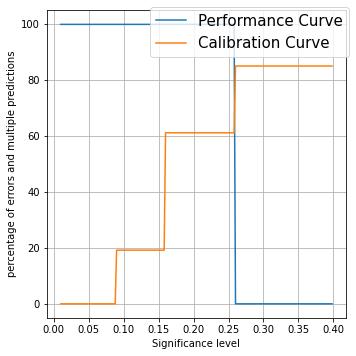

In [37]:
p_values=np.empty((len(val_labels),num_classes))
    
if nc_function=='knn':
    for i in range(len(val_labels)):
        test_ICP_candidates_temp=train_labels[indices[0]]
        for j in range(num_classes):
            temp_nc=knn_neighbors-np.count_nonzero(test_ICP_candidates_temp==j)
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)
        
if nc_function=='nearest_centroid':
    with open(nearest_centroid_nc_scores_path, "rb") as f:
        calibration_nc=pickle.load(f)
    centroid_distances=np.zeros(num_classes)
    for i in range(len(data['y_validation'])):
        for j in range(num_classes):
            centroid_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
        for j in range(num_classes):
            temp_nc=centroid_distances[j]/np.min(centroid_distances[np.arange(len(centroid_distances))!=j])
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)

opt_epsilon=np.max(np.sort(p_values,axis=1)[:,-2])
print("Optimal Epsilon:",opt_epsilon)
opt_epsilon_idx=np.searchsorted(significance_levels,opt_epsilon)
print("Discrete Optimal Epsilon:",significance_levels[opt_epsilon_idx])
print("Optimal Epsilon Index:", opt_epsilon_idx)

mult_labels=np.empty(len(significance_levels))
calib=np.empty(len(significance_levels))
for k,sl in enumerate(significance_levels):
    count_mult=0
    count_correct=0
    for i in range(len(val_labels)):
        count_correct+=(val_labels[i] in np.argwhere(p_values[i]>=sl))
        if np.count_nonzero(p_values[i]>=sl)>1:
            count_mult+=1
    mult_labels[k]=count_mult/len(val_labels)
    calib[k]=count_correct/len(val_labels)

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.plot(significance_levels,mult_labels*100,label='Performance Curve')
ax.plot(significance_levels,(1-calib)*100,label='Calibration Curve')
ax.set_xlabel("Significance level")
ax.set_ylabel("percentage of errors and multiple predictions")
ax.grid()
lgd=fig.legend(fontsize=15)
fig.tight_layout()
plt.savefig("Plots/compute_epsilon", bbox_extra_artists=(lgd,),bbox_inches='tight')

## Test

### P-values computation
Compute the p-values of all the labels for the test data

In [60]:
p_values=np.empty((len(data['y_test']),num_classes))
    
if nc_function=='knn':
    with open(knn_nc_scores_path, "rb") as f:
        calibration_nc,train_data_knn=pickle.load(f)
    for i in range(len(data['y_test'])):
        indices = train_data_knn.kneighbors(test_embeds[i].reshape(1, -1), return_distance=False)
        test_ICP_candidates_temp=data['y_train'][indices[0]]
        for j in range(num_classes):
            temp_nc=knn_neighbors-np.count_nonzero(test_ICP_candidates_temp==j)
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)
        
if nc_function=='nearest_centroid':
    with open(nearest_centroid_nc_scores_path, "rb") as f:
        calibration_nc=pickle.load(f)
    centroid_distances=np.zeros(num_classes)
    for i in range(len(data['y_test'])):
        for j in range(num_classes):
            centroid_distances[j]=np.linalg.norm(test_embeds[i]-centroids[j])
        for j in range(num_classes):
            temp_nc=centroid_distances[j]/np.min(centroid_distances[np.arange(len(centroid_distances))!=j])
            if p_value_type=="regular":
                p_values[i,j]=np.count_nonzero(calibration_nc>=temp_nc)/len(calibration_nc)
            if p_value_type=="smooth":
                p_values[i,j]=(np.count_nonzero(calibration_nc>temp_nc)+np.random.uniform(size=1)*np.count_nonzero(calibration_nc==temp_nc))/len(calibration_nc)

np.save(test_pvalues_path,p_values)

### Compute the prediction sets
Use the computed p-values of the test set to compute the prediction sets for different values of $\epsilon$

In [62]:
p_values=np.load(test_pvalues_path)

prediction_sets=[]
prediction_set_lengths=np.empty((len(significance_levels),len(data['y_test'])))

for k,sl in enumerate(significance_levels):
    sig_lev_set=[]
    for i in range(len(data['y_test'])):
        temp_set=[]
        for j in range(num_classes):
            if p_values[i,j]>=sl:
                temp_set.append(j)
        sig_lev_set.append(temp_set)
        prediction_set_lengths[k,i]=len(temp_set)
    prediction_sets.append(sig_lev_set)

with open(prediction_sets_path, "wb") as f:
    pickle.dump((prediction_sets,prediction_set_lengths), f)

In [73]:
def compute_multiples_errors(data,p_values,epsilon):
    count_mult=0
    count_correct=0
    for i in range(len(data['y_test'])):
        count_correct+=(data['y_test'][i] in np.argwhere(p_values[i]>=epsilon))
        if np.count_nonzero(p_values[i]>=epsilon)>1:
            count_mult+=1
    mult_labels=count_mult/len(data['y_test'])
    acc=count_correct/len(data['y_test'])
    return mult_labels,1-acc

print("Optimal epsilon", opt_epsilon)
print("Multiple predictions and errors are:",compute_multiples_errors(data,p_values,opt_epsilon))
print("Chosen epsilon 0.05")
print("Multiple predictions and errors are:",compute_multiples_errors(data,p_values,0.05))
print("Chosen epsilon 0.1")
print("Multiple predictions and errors are:",compute_multiples_errors(data,p_values,0.1))

Optimal epsilon 0.08044806517311609
Multiple predictions and errors are: (0.023809523809523808, 0.06959706959706957)
Chosen epsilon 0.05
Multiple predictions and errors are: (0.08974358974358974, 0.0494505494505495)
Chosen epsilon 0.1
Multiple predictions and errors are: (0.0, 0.09706959706959706)
